# 示例：轴承故障诊断

In [1]:
from torch import nn

from rulframework.data.FeatureExtractor import FeatureExtractor
from rulframework.data.labeler.FaultLabeler import FaultLabeler
from rulframework.data.loader.bearing.XJTULoader import XJTULoader
from rulframework.data.processor.RMSProcessor import RMSProcessor
from rulframework.entity.Bearing import Fault
from rulframework.model.pytorch.PytorchModel import PytorchModel
from rulframework.data.stage.BearingStageCalculator import BearingStageCalculator
from rulframework.data.stage.eol.NinetyThreePercentRMSEoLCalculator import NinetyThreePercentRMSEoLCalculator
from rulframework.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from rulframework.model.pytorch.basic.CNN import CNN
from rulframework.util.Plotter import Plotter

# 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [2]:
data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
eol_calculator = NinetyThreePercentRMSEoLCalculator()
stage_calculator = BearingStageCalculator(fpt_calculator, eol_calculator, data_loader.continuum)

DEBUG - 15:50:10 >> 
<< Root directory of dataset: D:\data\dataset\XJTU-SY_Bearing_Datasets
	Bearing1_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
	Bearing1_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
	Bearing1_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
	Bearing1_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
	Bearing1_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
	Bearing2_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
	Bearing2_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
	Bearing2_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
	Bearing2_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
	Bearing2_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
	Bearing3_1, location: D:\data\dataset\XJTU-SY_Bearing_Dat

# 获取原始数据、特征数据、阶段数据

In [3]:
bearing = data_loader("Bearing1_3", 'Horizontal Vibration')
feature_extractor(bearing)
stage_calculator(bearing)

INFO - 15:50:10 >> Loading data entity: Bearing1_3
INFO - 15:50:12 >> Successfully loaded data entity: Bearing1_3


# 生成训练数据

In [4]:
fault_types = [Fault.NC, Fault.OF, Fault.IF, Fault.CF]
labeler = FaultLabeler(2048, fault_types, is_onehot=False)
dataset = labeler(bearing)

# 通过其他轴承增加训练数据

In [5]:
for bearing_name in ['Bearing1_1', 'Bearing1_4', 'Bearing2_1', 'Bearing1_2', 'Bearing2_3']:
    bearing_train = data_loader(bearing_name, 'Horizontal Vibration')
    feature_extractor(bearing_train)
    stage_calculator(bearing_train)
    another_dataset = labeler(bearing_train)
    dataset.append(another_dataset)

INFO - 15:50:12 >> Loading data entity: Bearing1_1
INFO - 15:50:16 >> Successfully loaded data entity: Bearing1_1
INFO - 15:50:16 >> Loading data entity: Bearing1_4
INFO - 15:50:20 >> Successfully loaded data entity: Bearing1_4
INFO - 15:50:20 >> Loading data entity: Bearing2_1
INFO - 15:50:36 >> Successfully loaded data entity: Bearing2_1
INFO - 15:50:36 >> Loading data entity: Bearing1_2
INFO - 15:50:41 >> Successfully loaded data entity: Bearing1_2
INFO - 15:50:41 >> Loading data entity: Bearing2_3
INFO - 15:50:58 >> Successfully loaded data entity: Bearing2_3


# 划分训练集与测试集

In [6]:
train_set, test_set = dataset.split(0.7)

# 定义模型并训练

INFO - 15:50:58 >> 
<< Successfully initialized model:
	device: cuda
	dtype: torch.float32
INFO - 15:50:58 >> Start training model...
DEBUG - 15:51:00 >> Epoch 1/10, Loss: 0.7391647105
DEBUG - 15:51:00 >> Epoch 2/10, Loss: 0.3518396627
DEBUG - 15:51:01 >> Epoch 3/10, Loss: 0.2617774418
DEBUG - 15:51:01 >> Epoch 4/10, Loss: 0.2324543653
DEBUG - 15:51:02 >> Epoch 5/10, Loss: 0.2078691312
DEBUG - 15:51:02 >> Epoch 6/10, Loss: 0.1981737526
DEBUG - 15:51:03 >> Epoch 7/10, Loss: 0.1672708001
DEBUG - 15:51:03 >> Epoch 8/10, Loss: 0.1649118637
DEBUG - 15:51:04 >> Epoch 9/10, Loss: 0.1694067691
DEBUG - 15:51:04 >> Epoch 10/10, Loss: 0.1524245592
INFO - 15:51:04 >> Model training completed!!!


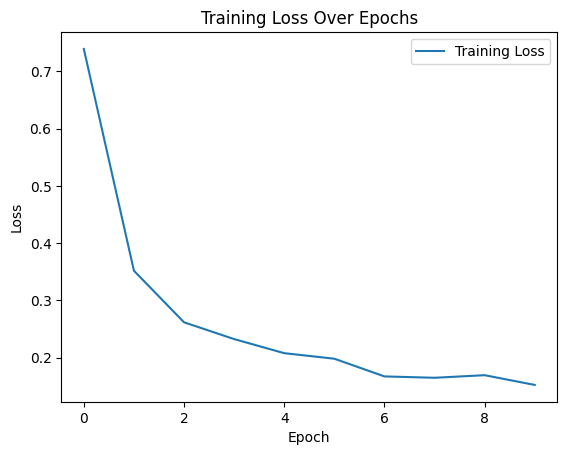

'Training Loss Over Epochs'

In [7]:
model = PytorchModel(CNN(2048, len(fault_types)))
model.train(train_set, 10, weight_decay=0.01, criterion=nn.CrossEntropyLoss())
Plotter.loss(model)

# 预测

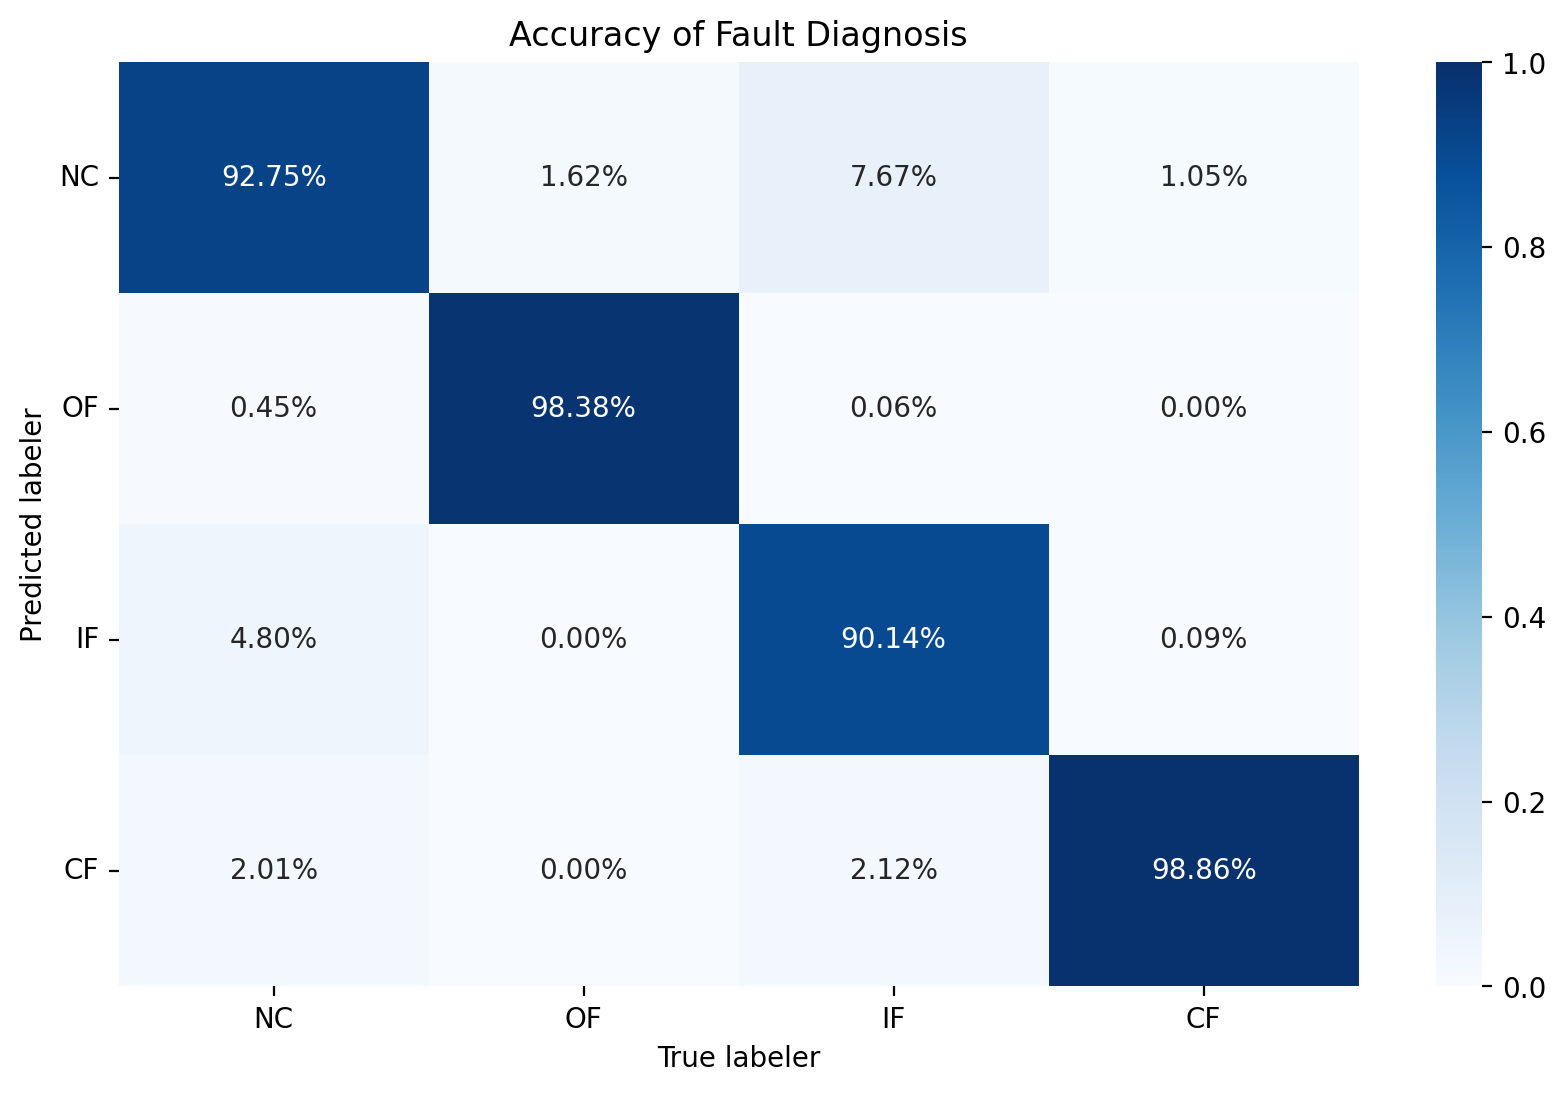

'Accuracy of Fault Diagnosis'

In [8]:
result = model.test(test_set)
Plotter.fault_diagnosis_heatmap(test_set, result, types=fault_types)